# Problem 4: distance-3 surface code

In [32]:
# There's a dependency in Bloqade that (currently)
# spits out some warnings you don't need to worry about.
import warnings
warnings.filterwarnings("ignore")

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin.rewrite import Walk
from bloqade import qasm2
from bloqade.qasm2.parse.lowering import QASM2
from bloqade.qasm2.passes import QASM2Py
from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

from kirin import ir
from qiskit import QuantumCircuit

from bloqade.qasm2.rewrite.native_gates import RydbergGateSetRewriteRule
from kirin import ir
from kirin.rewrite import Walk
from bloqade.qasm2.passes import UOpToParallel, QASM2Fold

from bloqade.qasm2.emit import QASM2 # the QASM2 target
from bloqade.qasm2.parse import pprint # the QASM2 pretty printer

target = QASM2(allow_parallel=True)

import numpy as np


@ir.dialect_group(qasm2.extended)
def extended_opt(self):
    native_rewrite = Walk(RydbergGateSetRewriteRule(self)) # use Kirin's functionality to walk code line by line while applying neutral-atom gate decomposition as defined in Bloqade
    parallelize_pass = UOpToParallel(self) # review the code and apply parallelization using a heuristic
    agg_fold = QASM2Fold(self) # supports parallelization by unfolding loops to search for parallelization opportunities

    # here we define our new compiler pass
    def run_pass(
        kernel: ir.Method,
        *,
        fold: bool = True,
        typeinfer: bool = True,
        parallelize: bool = False,
    ):
        assert qasm2.extended.run_pass is not None
        qasm2.extended.run_pass(kernel, fold=fold, typeinfer=typeinfer) # apply the original run_pass to the lowered kernel
        native_rewrite.rewrite(kernel.code) # decompose all gates in the circuit to neutral atom gate set

        # here goes our parallelization optimizer; the order of the commands here matters!
        if parallelize:
            agg_fold.fixpoint(kernel)
            parallelize_pass(kernel)

    return run_pass


# helper to go from Method → Qiskit
def method_to_qiskit(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # run extended pass in case forgot
    extended_opt.run_pass(method, parallelize=parallelize)
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

def method_to_qiskit_noparallel(method: ir.Method, *,parallelize: bool = True) -> QuantumCircuit:
    # emit OpenQASM2 text
    qasm = QASM2().emit_str(method)
    # parse into a Qiskit circuit
    return QuantumCircuit.from_qasm_str(qasm)

def print_gate_counts(ast): 
    """
    Print the counts of parallel and non parallel in the given AST,
    Distinguishing between single U and CZ gates and their parallelized versions.
    """
    test_string = qasm2.parse.spprint(ast)

    parallel_cz_count = test_string.count("parallel.CZ")
    parallel_u_count = test_string.count("parallel.U")
    u_count = test_string.count("U")  # To avoid counting "parallel.U"
    cz_count = test_string.count("cz")

    print(f"parallel CZ: {parallel_cz_count}")
    print(f"parallel U: {parallel_u_count}")
    print(f"other U: {u_count - parallel_u_count}")
    print(f"other CZ: {cz_count}")

## Reference circuit

In [60]:
def basemethod(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def basemethod_program():
        q = qasm2.qreg(17)
        qasm2.h(q[4])
        qasm2.h(q[6])
        qasm2.h(q[10])
        qasm2.h(q[12])
        qasm2.cx(q[3],q[0])
        qasm2.cx(q[4],q[7])
        qasm2.cx(q[10],q[14])
        qasm2.cx(q[6],q[9])
        qasm2.cx(q[15],q[11])
        qasm2.cx(q[8],q[5])
        qasm2.cx(q[4],q[1])
        qasm2.cx(q[7],q[5])
        qasm2.cx(q[10],q[8])
        qasm2.cx(q[14],q[11])
        qasm2.cx(q[6],q[3])
        qasm2.cx(q[2],q[0])
        qasm2.cx(q[2],q[5])
        qasm2.cx(q[6],q[8])
        qasm2.cx(q[10],q[13])
        qasm2.cx(q[14],q[16])
        qasm2.cx(q[9],q[11])
        qasm2.cx(q[12],q[15])
        qasm2.cx(q[10],q[7])
        qasm2.cx(q[6],q[2])
        qasm2.cx(q[13],q[16])
        qasm2.cx(q[12],q[9])
        qasm2.cx(q[1],q[5])
        qasm2.cx(q[8],q[11])
        qasm2.h(q[4])
        qasm2.h(q[6])
        qasm2.h(q[10])
        qasm2.h(q[12])
        return q

    return basemethod_program

In [36]:
print_gate_counts(target.emit(basemethod(parallelize=True)))

parallel CZ: 7
parallel U: 30
other U: 15
other CZ: 4


In [37]:
qasm2.parse.pprint(target.emit(basemethod(parallelize=True)))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg Qbits[17];
parallel.U(1.5707963267949, 0.0, 3.14159265358979) {
  Qbits[4];
  Qbits[6];
  Qbits[10];
  Qbits[12];
}
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  Qbits[0];
  Qbits[7];
  Qbits[14];
  Qbits[9];
  Qbits[11];
  Qbits[5];
  Qbits[1];
  Qbits[13];
  Qbits[16];
}
parallel.CZ {
  Qbits[3], Qbits[0];
  Qbits[4], Qbits[7];
  Qbits[10], Qbits[14];
  Qbits[6], Qbits[9];
  Qbits[15], Qbits[11];
  Qbits[8], Qbits[5];
}
parallel.U(1.5707963267949, 3.14159265358979, 3.14159265358979) {
  Qbits[0];
  Qbits[7];
  Qbits[14];
  Qbits[9];
  Qbits[11];
  Qbits[5];
}
parallel.U(0.0, 0.0, 3.14159265358979) {
  Qbits[3];
  Qbits[4];
  Qbits[10];
  Qbits[6];
  Qbits[15];
  Qbits[8];
}
parallel.U(0.0, 0.0, 6.28318530717958) {
  Qbits[0];
  Qbits[7];
  Qbits[14];
  Qbits[9];
  Qbits[11];
  Qbits[5];
}
cz Qbits[4], Qbits[1];
U(1.5707963267949, 3.1

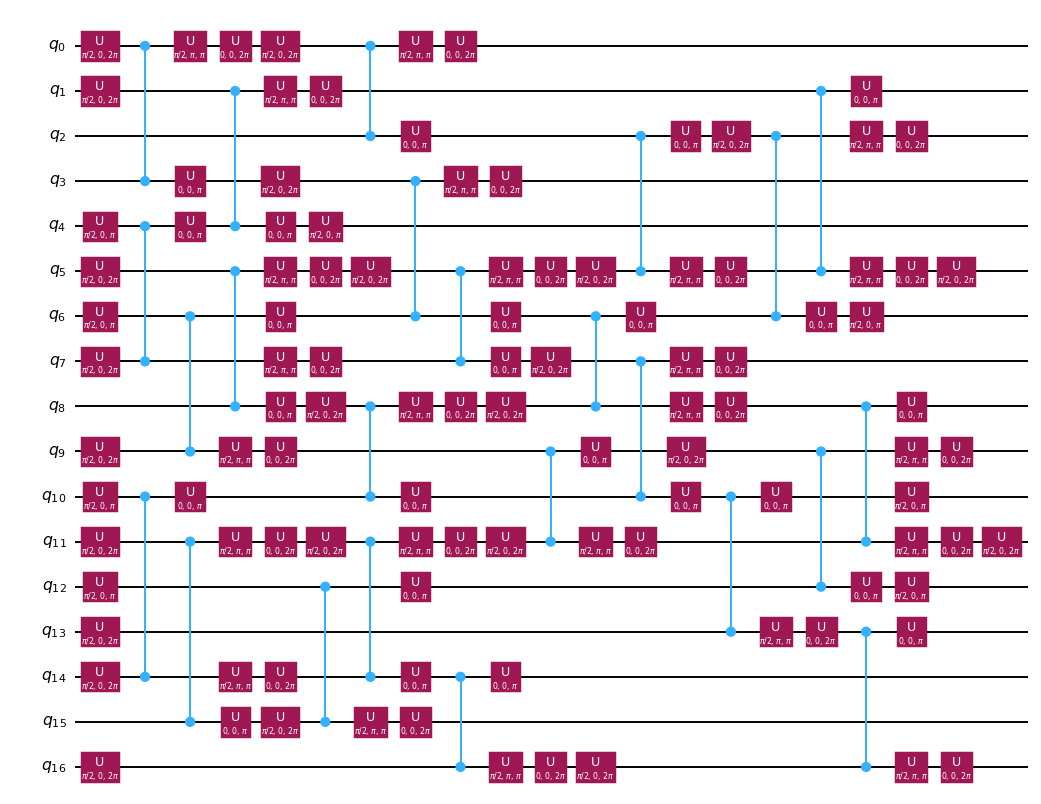

In [61]:
qc = method_to_qiskit(basemethod(parallelize=True))
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=0.7)
display(fig)   # in a Jupyter notebook

## Optimized circuit

In [57]:
def method(parallelize: bool = False):

    @extended_opt(parallelize=parallelize)
    def method_program():
        q = qasm2.qreg(17)
        qasm2.h(q[4])
        qasm2.h(q[6])
        qasm2.h(q[10])
        qasm2.h(q[12])
        qasm2.cx(q[3],q[0])
        qasm2.cx(q[6],q[9])
        qasm2.cx(q[10],q[14])
        qasm2.cx(q[4],q[7])
        qasm2.cx(q[8],q[5])
        qasm2.cx(q[15],q[11])
        qasm2.cx(q[4],q[1])
        qasm2.cx(q[7],q[5])
        qasm2.cx(q[10],q[8])
        qasm2.cx(q[14],q[11])
        qasm2.cx(q[2],q[0])
        qasm2.cx(q[6],q[3])
        qasm2.cx(q[12],q[15])
        qasm2.cx(q[2],q[5])
        qasm2.cx(q[6],q[8])
        qasm2.cx(q[10],q[13])
        qasm2.cx(q[14],q[16])
        qasm2.cx(q[9],q[11])
        qasm2.cx(q[10],q[7])
        qasm2.cx(q[6],q[2])
        qasm2.cx(q[12],q[9])
        qasm2.cx(q[13],q[16])
        qasm2.cx(q[1],q[5])
        qasm2.cx(q[8],q[11])
        qasm2.h(q[4])
        qasm2.h(q[6])
        qasm2.h(q[10])
        qasm2.h(q[12])
        return q

    return method_program

In [39]:
print_gate_counts(target.emit(method(parallelize=True)))

parallel CZ: 7
parallel U: 30
other U: 15
other CZ: 4


In [58]:
qasm2.parse.pprint(target.emit(method(parallelize=True)))

KIRIN {func,lowering.call,lowering.func,py.ilist,qasm2.core,qasm2.expr,qasm2.indexing,qasm2.parallel,qasm2.uop,scf};
include "qelib1.inc";
qreg q[17];
parallel.U(1.5707963267949, 0.0, 3.14159265358979) {
  q[4];
  q[6];
  q[10];
  q[12];
}
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  q[0];
  q[9];
  q[14];
  q[7];
  q[5];
  q[11];
  q[1];
  q[13];
  q[16];
}
parallel.CZ {
  q[3], q[0];
  q[6], q[9];
  q[10], q[14];
  q[4], q[7];
  q[8], q[5];
  q[15], q[11];
}
parallel.U(1.5707963267949, 3.14159265358979, 3.14159265358979) {
  q[0];
  q[9];
  q[14];
  q[7];
  q[5];
  q[11];
}
parallel.U(0.0, 0.0, 3.14159265358979) {
  q[3];
  q[6];
  q[10];
  q[4];
  q[8];
  q[15];
}
parallel.U(0.0, 0.0, 6.28318530717958) {
  q[0];
  q[9];
  q[14];
  q[7];
  q[5];
  q[11];
}
cz q[4], q[1];
U(1.5707963267949, 3.14159265358979, 3.14159265358979) q[1];
U(0.0, 0.0, 3.14159265358979) q[4];
U(0.0, 0.0, 6.28318530717958) q[1];
parallel.U(1.5707963267949, 0.0, 6.28318530717959) {
  q[5];
  q[11];
  q

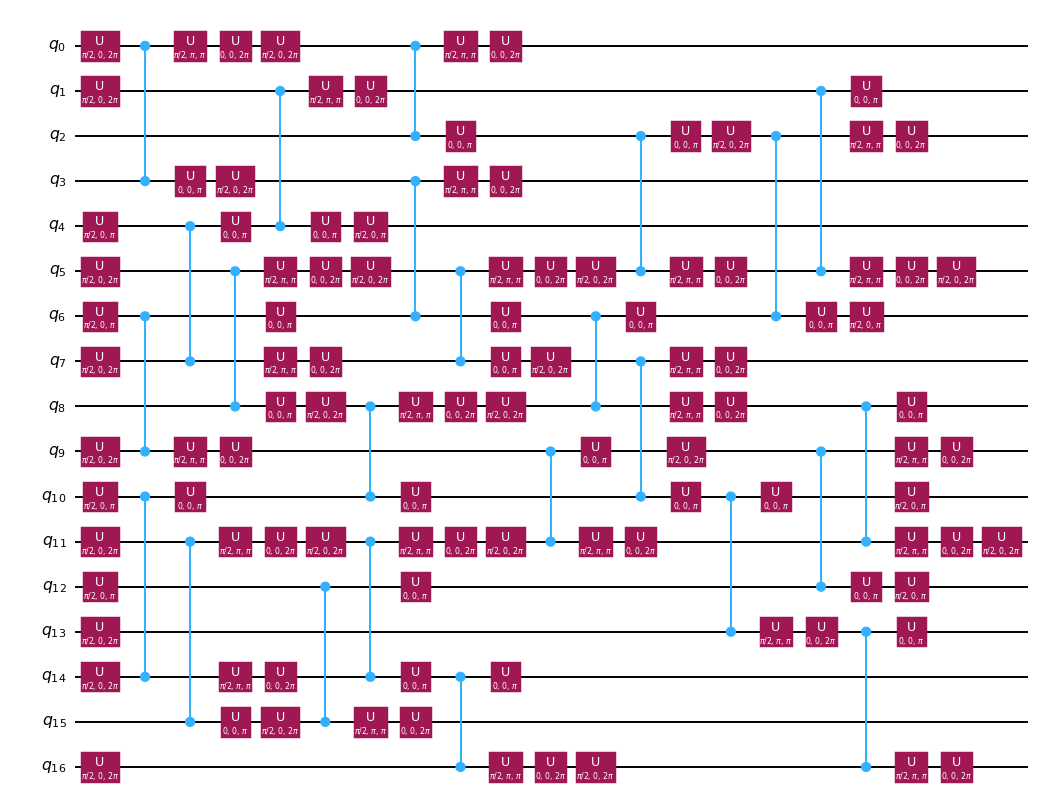

In [59]:
qc = method_to_qiskit(method(parallelize=True))
#print(qc.draw(output="text"))
fig = qc.draw(output="mpl", fold=120, scale=0.7)
display(fig)   # in a Jupyter notebook

## Simulate

In [41]:
from bloqade.pyqrack import PyQrack
from collections import Counter
from qiskit.quantum_info import Statevector, Operator

basekernel = basemethod(parallelize=True)
kernel = method(parallelize=True)

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})
basereg = device.run(basekernel)
reg = device.run(kernel)

In [50]:
qbit = basereg[0]
basefinalstate = Statevector(qbit.sim_reg.out_ket())
display(basefinalstate.draw("latex"))

<IPython.core.display.Latex object>

In [53]:
qbit = reg[0]
finalstate = Statevector(qbit.sim_reg.out_ket())
display(finalstate.draw("latex"))

<IPython.core.display.Latex object>

In [52]:
np.abs(finalstate.inner(basefinalstate))

0.9999986651729279

Nice!

## Now let's add noise

Unfortunately there is some issue with noise simulations with certain circuits: this is one of them.

In [54]:
from bloqade.qasm2.passes import NoisePass
from bloqade.noise import native
import numpy as np

# add noise
noise_kernel = kernel.similar()
extended_opt.run_pass(noise_kernel, parallelize=True)
NoisePass(extended_opt)(noise_kernel)

noise_kernel = noise_kernel.similar(extended_opt.add(native))

device = PyQrack(dynamic_qubits=True, pyqrack_options={"isBinaryDecisionTree": False})

Nshots = 100

noisy_states = [r[0].sim_reg.out_ket() for r in device.multi_run(noise_kernel, _shots = Nshots)]

fidelity = 0
for i in range(Nshots):
    fidelity = fidelity + np.abs(np.vdot(noisy_states[i],finalstate))**2

fidelity = fidelity/Nshots
print(fidelity)

InterpreterError: SSAValue <ResultValue[Qubit] stmt: qreg.get, uses: 21> not found